In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/

/content


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=(3,3), stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=(3,3), stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=181):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=(1,3), stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=1)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=1)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=1)
        self.linear = nn.Linear(25, num_classes)
        #self.flat = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1)
        self.flat = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, stride=1))

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # print("Input ==> ", x.size())
        out = F.relu(self.bn1(self.conv1(x)))
        # print("F.relu(self.bn1(self.conv1(x))) ==> ", x.size())
        out = self.layer1(out)
        # print("layer1 ==> ", x.size())
        out = self.layer2(out)
        # print("layer2 ==> ", x.size())
        out = self.layer3(out)
        # print("layer3 ==> ", x.size())
        out = self.layer4(out)
        # print("layer4 ==>", out.size())
        out = F.avg_pool2d(out, (6,4))
        # print("avg_pool2d ===>", out.size())
        # out = out.view(out.size(0), -1)
        # print("out.view ===>", out.size())
        out = self.linear(out)
        out = self.flat(out)
        # print("Out ===>", out.size())
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])

def ResNet101():
    return ResNet(BasicBlock, [3, 4, 23, 3])


if __name__ == "__main__":
    image = torch.rand(1, 3, 8, 100)
    model = ResNet34()
    model(image)


In [4]:
import scipy.io as sio
import numpy as np
import torch
import os
from os import listdir
from os.path import isfile, join
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np 
import math
import pandas as pd
import cmath
import scipy.io as sio
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np 
import math
import pandas as pd
import cmath

#from unet import UNet
# from auto import encoder, decoder

from collections import OrderedDict
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
#==========================================================================
# For Plotting loss graph
# Bokeh
from bokeh.io import curdoc
from bokeh.layouts import column
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure

from functools import partial
from threading import Thread
from tornado import gen
# from AttRCNN_UNet import Att_R2U
import logging
logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import sys
# from dataloader import norm

# import wandb
# import logging
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO)
import csv
from sklearn.model_selection import train_test_split
from sys import getsizeof

In [5]:
train_dataset_list = []
test_dataset_list = []

In [6]:
df1  = sio.loadmat("/content/drive/MyDrive/DOA/DOA1/doa1/SNR_NS_0_1_100000.mat")
df2  = sio.loadmat("/content/drive/MyDrive/DOA/DOA1/doa1/SNR_NS_10_1_100000.mat")
df3  = sio.loadmat("/content/drive/MyDrive/DOA/DOA1/doa1/SNR_NS_20_1_100000.mat")
df4  = sio.loadmat("/content/drive/MyDrive/DOA/DOA1/doa1/SNR_NS_30_1_100000.mat")
df5  = sio.loadmat("/content/drive/MyDrive/DOA/DOA1/doa1/SNR_NS_40_1_100000.mat")
df = [df1, df2, df3, df4, df5]
# getsizeof(df)

In [7]:
new_train_dataset_list = []
new_test_dataset_list = []
train_dataset_list_label = []
test_dataset_list_label = []

In [8]:
def create_dataset(df):
    data = np.transpose(df['NS_data'], (2, 0, 1))
    label = df['DOA']
    X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.15, random_state=42)
    new_train_dataset_list.extend(X_train)
    new_test_dataset_list.append(X_test.tolist())
    train_dataset_list_label.extend(y_train)
    test_dataset_list_label.append(y_test.tolist())

In [9]:
for file in df:
    create_dataset(file)

In [10]:
type(new_test_dataset_list[0])

list

In [11]:
del df
del df1
del df2
del df3
del df4
del df5

In [12]:
for idx, data in enumerate(new_train_dataset_list):
    new = np.zeros((3, 8, 100))
    for j in range(0, data.shape[0]):
        for k in range(0, data.shape[1]):
            new[0][j][k] = data[j][k].real
            new[1][j][k] = data[j][k].imag
            new[2][j][k] = cmath.phase(data[j][k])
    new_train_dataset_list[idx] = new

In [13]:
for idx, data in enumerate(new_test_dataset_list):
    for i, ndata in enumerate(data):
        new = np.zeros((3, 8, 100))
        for j in range(0, 8):
            for k in range(0, 100):
                new[0][j][k] = ndata[j][k].real
                new[1][j][k] = ndata[j][k].imag
                new[2][j][k] = cmath.phase(ndata[j][k])
        new_test_dataset_list[idx][i] = new

In [14]:
def get_data(train, test, batch_size, train_bool=True):
    class DOA_dataset(Dataset):
        def __init__(self, train, test):
            self.x = torch.from_numpy(np.array(train))
            self.y = torch.from_numpy(np.asarray(test))
            self.n_sample = len(self.y)
        def __getitem__(self, index):
            return self.x[index], self.y[index]
        def __len__(self):
            return self.n_sample


    dataset = DOA_dataset(train, test)
    

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=train_bool)
    return loader


In [15]:
doa2_train_loader = get_data(new_train_dataset_list, train_dataset_list_label, 64, True)

In [16]:
del new_train_dataset_list
del train_dataset_list_label

In [17]:
test_dataset_list = []

In [18]:
for idx, data in enumerate(new_test_dataset_list):
    print(type(data))
    f = get_data(data, test_dataset_list_label[idx], 128, False)
    test_dataset_list.append(f)

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


In [19]:
del new_test_dataset_list
del new

In [ ]:
len(test_dataset_list)

5

In [ ]:
#test_dataset_list
#doa2_train_loader

##Triplet loss

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import logging
from torchvision import models
import numpy as np
import torch.nn.functional as F

def double_conv1(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(4,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(4,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

def double_conv2(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(4,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(4,2), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv
def double_conv3(in_c, out_c):
    conv = nn.Sequential(
        nn.Conv2d(in_c, out_c, kernel_size=(4,2),padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, kernel_size=(3,2), padding=1 ,stride=1, bias=True),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True))
    return conv

class cnn(nn.Module):
    def __init__(self,img_ch=3,output_ch=1):
        super(cnn, self).__init__()
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=(2,1), stride=1)
        self.down_conv_1 = double_conv1(img_ch, 64)
        self.down_conv_2 = double_conv2(64, 128)
        self.down_conv_3 = double_conv3(128, 256)
        self.out = nn.Conv2d(
            in_channels=256,
            out_channels=output_ch,
            kernel_size=1,stride=1,padding=0)
        self.fc1 = nn.Linear(106, 150)
        self.fc2 = nn.Linear(150, 170)
        self.fc3 = nn.Linear(170, 181)
        # self.linear = nn.Linear(25, num_classes)
    def forward(self, image):
        # cnn
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        # print(x3.size())
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.fc1(x5)
        x7 = self.fc2(x6)
        x8 = self.fc3(x7)
        out = self.out(x8)
        # print(out.size())
        return out





if __name__ == "__main__":
    image = torch.rand(1, 3, 8, 100)
    en = cnn()
    en(image)




In [20]:
num_epochs = 50
doa = 1
weights_dir = "/content/drive/MyDrive/DOA/doa_weights/"

autoencoder = ResNet34()
criterion = nn.CrossEntropyLoss()
if ('DOA_{}_model.pth'.format(doa) in [f for f in listdir(weights_dir) if isfile(join(weights_dir, f))]):
    print("Pre-trained available for DOA_{}_model.pth".format(doa))
    autoencoder = torch.load(os.path.join(weights_dir, 'DOA_{}_model.pth'.format(doa)))

if torch.cuda.is_available():
	print(torch.cuda.get_device_name(0))
	classification_model = autoencoder.cuda()
	optimizer = optim.AdamW(classification_model.parameters(), lr=0.001, weight_decay=1e-5)
	criterion = criterion.cuda()

Pre-trained available for DOA_1_model.pth
Tesla V100-SXM2-16GB


In [22]:
acc_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}
loss_res = {
    "training": [],
    0: [],
    10: [],
    20: [],
    30: [],
    40: []
}

In [23]:
import pandas as pd

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}, Training MAE: {}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total)), training_mae/len(doa2_train_loader)))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}, Validation MAE: {}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total)), validation_mae/len(test_dataset_list[val_data])))

                total_valdation_loss+=validation_loss
            torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(doa))
            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_best_model.pth".format(doa))
            # if best_valid_loss > total_valdation_loss:
            #     best_valid_loss = total_valdation_loss 
            #     # Saving Best Pre-Trained Model as .pth file
            #     torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(doa))
        if i%10 == 0:
          ddf = pd.DataFrame(acc_res)
          ddf.to_csv("/content/drive/MyDrive/DOA/doa_weights/res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 0.6845, Training Accuracy: 73.2640, Training MAE: 213.27525975003763
SNR [0dB], Validation Loss: 1.1691, Validation Accuracy: 54.9267, Validation MAE: 694.2118644067797
SNR [10dB], Validation Loss: 0.4748, Validation Accuracy: 81.6733, Validation MAE: 405.09322033898303
SNR [20dB], Validation Loss: 0.3198, Validation Accuracy: 87.4333, Validation MAE: 295.22033898305085
SNR [30dB], Validation Loss: 0.3042, Validation Accuracy: 88.3533, Validation MAE: 278.85593220338984
SNR [40dB], Validation Loss: 0.3086, Validation Accuracy: 87.8733, Validation MAE: 297.3728813559322


Epoch [2/50], Training Loss: 0.4726, Training Accuracy: 81.9974, Training MAE: 184.10932088540883
SNR [0dB], Validation Loss: 1.0490, Validation Accuracy: 61.5800, Validation MAE: 606.6440677966102
SNR [10dB], Validation Loss: 0.3860, Validation Accuracy: 85.7467, Validation MAE: 287.3305084745763
SNR [20dB], Validation Loss: 0.2289, Validation Accuracy: 92.0733, Val

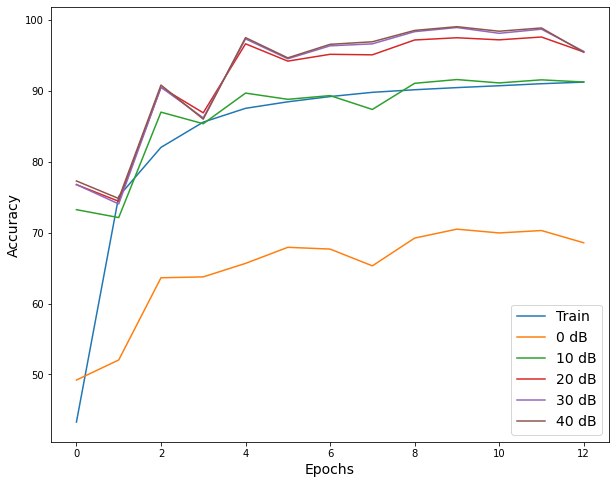

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, 13)
plt.figure(figsize=(10, 8))
plt.plot(ep, acc_res["training"], label='Train')
plt.plot(ep, acc_res[0], label='0 dB')
plt.plot(ep, acc_res[10], label='10 dB')
plt.plot(ep, acc_res[20], label='20 dB')
plt.plot(ep, acc_res[30], label='30 dB')
plt.plot(ep, acc_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)
plt.savefig("DOA1_resnet34")
plt.show()

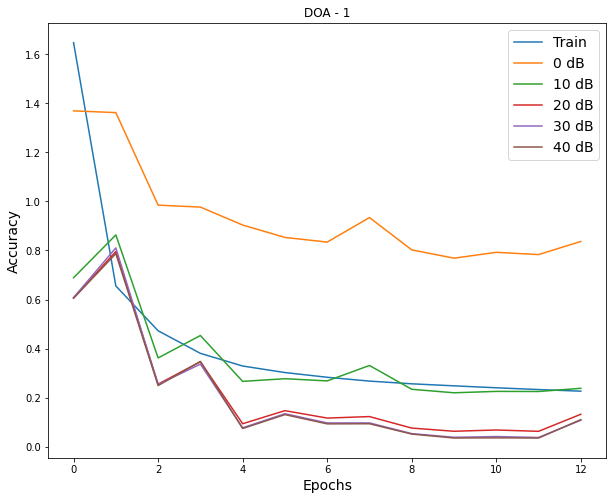

In [ ]:
import matplotlib.pyplot as plt
ep = range(0, 13)
plt.figure(figsize=(10, 8))
plt.plot(ep, loss_res["training"], label='Train')
plt.plot(ep, loss_res[0], label='0 dB')
plt.plot(ep, loss_res[10], label='10 dB')
plt.plot(ep, loss_res[20], label='20 dB')
plt.plot(ep, loss_res[30], label='30 dB')
plt.plot(ep, loss_res[40], label='40 dB')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title("DOA - 1")
plt.legend(fontsize=14)
plt.savefig("DOA3_resnet34")
plt.show()

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total))))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total))))

                total_valdation_loss+=validation_loss

            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(doa))
        if i%10 == 0:
          ddf = pd.DataFrame(acc_res)
          ddf.to_csv("/content/drive/MyDrive/DOA/doa_weights/res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 1.7795, Training Accuracy: 39.3539
SNR [0dB], Validation Loss: 1.5285, Validation Accuracy: 42.7667
SNR [10dB], Validation Loss: 0.8716, Validation Accuracy: 66.9667
SNR [20dB], Validation Loss: 0.7799, Validation Accuracy: 71.7867
SNR [30dB], Validation Loss: 0.7628, Validation Accuracy: 72.7467
SNR [40dB], Validation Loss: 0.7654, Validation Accuracy: 72.3667


Epoch [2/50], Training Loss: 0.7637, Training Accuracy: 71.0708
SNR [0dB], Validation Loss: 1.2194, Validation Accuracy: 54.4133
SNR [10dB], Validation Loss: 0.5076, Validation Accuracy: 80.5400
SNR [20dB], Validation Loss: 0.3972, Validation Accuracy: 84.8867
SNR [30dB], Validation Loss: 0.3948, Validation Accuracy: 85.0667
SNR [40dB], Validation Loss: 0.3930, Validation Accuracy: 84.7800


Epoch [3/50], Training Loss: 0.5231, Training Accuracy: 80.1508
SNR [0dB], Validation Loss: 1.0380, Validation Accuracy: 61.5267
SNR [10dB], Validation Loss: 0.4239, Validation Accuracy:

In [ ]:
def train():
    print("Training Starts !!!!!!!")
    best_valid_loss = float('Inf')
    for i in range(num_epochs):
        training_loss = 0
        train_correct = 0
        train_total = 0
        epoch_loss = 0.0
        training_mae = 0.0
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#           exp_scheduler.step()
            training_loss += losss.item()

            _, pred = torch.max(auto_outputs, 1)

            train_total+= labels.reshape(-1).size(0)

            train_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()

            epoch_loss += auto_outputs.shape[0] * losss.item()
            training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()  

        loss_res['training'].append(training_loss/len(doa2_train_loader))
        acc_res['training'].append((100*(train_correct/train_total)))

        print('Epoch [{}/{}], Training Loss: {:.4f}, Training Accuracy: {:.4f}'
                      .format(i+1, num_epochs, training_loss/len(doa2_train_loader), (100*(train_correct/train_total))))
        
        # Validation for each SNR value
        classification_model.eval()
        total_valdation_loss = 0
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_acc = 0
            validation_mae = 0.0
            val_correct = 0
            val_total = 0

            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    val_total+= labels.reshape(-1).size(0)
                    val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

                loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
                acc_res[10*val_data].append((100*(val_correct/val_total)))
                print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
                      .format(val_data*10, validation_loss/len(test_dataset_list[val_data]), (100*(val_correct/val_total))))

                total_valdation_loss+=validation_loss

            if best_valid_loss > total_valdation_loss:
                best_valid_loss = total_valdation_loss 
                # Saving Best Pre-Trained Model as .pth file
                torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(doa))
        if i%10 == 0:
          ddf = pd.DataFrame(acc_res)
          ddf.to_csv("/content/drive/MyDrive/DOA/doa_weights/res_DOA_{}_model.csv".format(doa))
        print("\n")  

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch [1/50], Training Loss: 1.7023, Training Accuracy: 40.8358
SNR [0dB], Validation Loss: 1.6776, Validation Accuracy: 39.5333
SNR [10dB], Validation Loss: 0.8713, Validation Accuracy: 64.9667
SNR [20dB], Validation Loss: 0.7169, Validation Accuracy: 70.0333
SNR [30dB], Validation Loss: 0.6993, Validation Accuracy: 70.2067
SNR [40dB], Validation Loss: 0.7012, Validation Accuracy: 70.1533


Epoch [2/50], Training Loss: 0.6988, Training Accuracy: 73.3033
SNR [0dB], Validation Loss: 1.2121, Validation Accuracy: 54.9267
SNR [10dB], Validation Loss: 0.4526, Validation Accuracy: 81.6800
SNR [20dB], Validation Loss: 0.2826, Validation Accuracy: 89.5800
SNR [30dB], Validation Loss: 0.2635, Validation Accuracy: 90.6467
SNR [40dB], Validation Loss: 0.2593, Validation Accuracy: 91.1600


Epoch [3/50], Training Loss: 0.4813, Training Accuracy: 81.7021
SNR [0dB], Validation Loss: 1.0925, Validation Accuracy: 58.7933
SNR [10dB], Validation Loss: 0.3854, Validation Accuracy:

In [ ]:
torch.save( model, "/content/drive/MyDrive/DOA/doa_weights/DOA_{}_model.pth".format(1))

In [ ]:
classification_model.eval()
total_valdation_loss = 0
for val_data in range(0, len(test_dataset_list)):
    
    validation_loss = 0
    validation_acc = 0
    validation_mae = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for features, labels in test_dataset_list[val_data]:
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
            loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

            _, pred = torch.max(auto_outputs, 1)
            val_total+= labels.reshape(-1).size(0)
            # print("######### pred ###########")
            # print(pred[0])
            # print("######### label ###########")
            # print(labels[0])
            val_correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            validation_loss += loss.item()
            validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()

        loss_res[10*val_data].append(validation_loss/len(test_dataset_list[val_data]))
        acc_res[10*val_data].append((100*(val_correct/val_total)))
    print(val_correct, val_total)
    print(val_data*10, "dB SNR is validated")
    print('SNR [{}dB], Validation Loss: {:.4f}, Validation Accuracy: {:.4f}'
              .format(val_data*10, validation_loss/len(doa2_train_loader), (100*(val_correct/val_total))))

93 15000
0 dB SNR is validated
SNR [0dB], Validation Loss: 0.1840, Validation Accuracy: 0.6200
98 15000
10 dB SNR is validated
SNR [10dB], Validation Loss: 0.1840, Validation Accuracy: 0.6533
100 15000
20 dB SNR is validated
SNR [20dB], Validation Loss: 0.1840, Validation Accuracy: 0.6667
113 15000
30 dB SNR is validated
SNR [30dB], Validation Loss: 0.1840, Validation Accuracy: 0.7533
95 15000
40 dB SNR is validated
SNR [40dB], Validation Loss: 0.1840, Validation Accuracy: 0.6333


In [ ]:
def train():
    print("Training Starts !!!!!!!")
    for i in range(50):
        training_loss = 0
        tcorrect = 0
        ttotal = 0
        epoch_loss = 0.0
        training_mae = 0.0
#         for data in range(0, len(train_dataset_list)):
        classification_model.train()
        for j,(features, labels) in enumerate(doa2_train_loader, 0):
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            optimizer.zero_grad()
            enn = classification_model(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs.cuda(), (auto_outputs.shape[0], 181, 1))
            losss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())
            losss.backward()
            optimizer.step()
#                 exp_scheduler.step()
            training_loss += losss.item()
            _, pred = torch.max(auto_outputs, 1)
            ttotal+= labels.reshape(-1).size(0)
            tcorrect+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            epoch_loss += auto_outputs.shape[0] * losss.item()
#             training_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' % (i + 1, j + 1, training_loss / 2000))
                training_loss = 0.0
#         wandb.log({"Trainig Acc":(100*(tcorrect/ttotal)), "Traningloss":(training_loss/len(train_dataset_list[data]))})
        res['training'].append((100*(tcorrect/ttotal)))
        print("Epoch {}  \nTraningloss: {}".format(i+1, training_loss/len(doa2_train_loader)), " ---- Trainig Acc: {}".format( 100*(tcorrect/ttotal)))
            
        classification_model.eval()
        for val_data in range(0, len(test_dataset_list)):
            
            validation_loss = 0
            validation_mae = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for features, labels in test_dataset_list[val_data]:
                    features, labels = Variable(features.cuda()), Variable(labels.cuda())
                    enn = classification_model(features.float())
                    auto_outputs = torch.transpose(enn, 2, 3)
                    auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
                    loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

                    _, pred = torch.max(auto_outputs, 1)
                    total+= labels.reshape(-1).size(0)
                    correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
                    validation_loss += loss.item()
                    validation_mae += torch.abs(pred.reshape(-1).cuda() - labels.reshape(-1)).sum().item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
            print(val_data*10, "dB SNR is validated")
            res[10*val_data].append((100*(correct/total)))
            print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
        print("\n")  
        # ep.append(i)
#     wandb.finish()
		

train()
print("Training Complete")

Training Starts !!!!!!!
Epoch 1  
Traningloss: 1.6993514241790773  ---- Trainig Acc: 36.534
0 dB SNR is validated
Validationloss: 2.0331047872069536  ---- Validation Acc: 27.41
10 dB SNR is validated
Validationloss: 1.1929842169117775  ---- Validation Acc: 52.22
20 dB SNR is validated
Validationloss: 1.1272904162953614  ---- Validation Acc: 55.54
30 dB SNR is validated
Validationloss: 1.1116065671489497  ---- Validation Acc: 56.56
40 dB SNR is validated
Validationloss: 1.113933415549576  ---- Validation Acc: 56.31


Epoch 2  
Traningloss: 1.2239338689422607  ---- Trainig Acc: 52.9305
0 dB SNR is validated
Validationloss: 1.8361590326212014  ---- Validation Acc: 34.81
10 dB SNR is validated
Validationloss: 0.8750992075652834  ---- Validation Acc: 64.01
20 dB SNR is validated
Validationloss: 0.7855386828920644  ---- Validation Acc: 69.39999999999999
30 dB SNR is validated
Validationloss: 0.7655144280688778  ---- Validation Acc: 69.87
40 dB SNR is validated
Validationloss: 0.7821353449942

KeyboardInterrupt: ignored

In [ ]:
!pip install pytorch-metric-learning

     |████████████████████████████████| 102kB 4.3MB/s 


In [ ]:
from pytorch_metric_learning import losses, miners, distances, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")

2021-05-09 14:27:37,847 - The pytorch-metric-learning testing module requires faiss. You can install the GPU version with the command 'conda install faiss-gpu -c pytorch'
                        or the CPU version with 'conda install faiss-cpu -c pytorch'. Learn more at https://github.com/facebookresearch/faiss/blob/master/INSTALL.md


In [ ]:
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = Variable(data.cuda()), Variable(labels.cuda())
        optimizer.zero_grad()
        embeddings = model(data.float())
        print(embeddings.size(), labels.size())
        indices_tuple = mining_func(embeddings, labels.reshape(-1))
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 1400 == 0:
            print("Epoch {} Iteration {}: Loss = {}, Number of mined triplets = {}".format(epoch, batch_idx, loss, mining_func.num_triplets))

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)

def test(testloader, model):
    model.eval()
    validation_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for features, labels in testloader:
            features, labels = Variable(features.cuda()), Variable(labels.cuda())
            enn = autoencoder(features.float())
            auto_outputs = torch.transpose(enn, 2, 3)
            auto_outputs = torch.reshape(auto_outputs, (auto_outputs.shape[0], 181, 1))
            loss = criterion(auto_outputs.cuda(), labels.type(torch.LongTensor).cuda())

            _, pred = torch.max(auto_outputs, 1)
            total+= labels.reshape(-1).size(0)
            correct+=(pred.reshape(-1).cuda() == labels.reshape(-1)).sum().item()
            validation_loss += loss.item()
#             wandb.log({"Validation Acc "+str(val_data):(100*(correct/total)),"Validation Loss "+str(val_data):( validation_loss/len(test_dataset_list[val_data]))})
    print(val_data*10, "dB SNR is validated")
#     vl1[val_data].append((100*(correct/total)))
    print("Validationloss: {}".format( validation_loss/len(test_dataset_list[val_data])), " ---- Validation Acc: {}".format(100*(correct/total)))
print("\n")  
    
    
device = torch.device("cuda")

model = autoencoder.cuda()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### pytorch-metric-learning stuff ###
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0)
loss_func = losses.NTXentLoss(temperature=0.07) #losses.TripletMarginLoss(margin = 0.2, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.2, distance = distance, type_of_triplets = "semihard")
accuracy_calculator = AccuracyCalculator(include = ("precision_at_1",), k = 1)


In [ ]:
for epoch in range(0, 50):
    train(classification_model, loss_func, mining_func, device, doa2_train_loader, optimizer, epoch+1)
    for val_data in range(0, len(test_dataset_list)):
        print("Validation has started for ", str(val_data*10), "dB SNR" )
        test(doa2_train_loader, test_dataset_list[val_data], model, accuracy_calculator)

torch.Size([64, 1, 1, 181]) torch.Size([64, 1])


RuntimeError: ignored